## Detect Peaks

In [2]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False):

    """
    
    Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
        
    mph : {None, number}, default=None
        detect peaks that are greater than minimum peak height.
        
    mpd : int, default=1
        detect peaks that are at least separated by minimum peak distance (in number of data).
        
    threshold : int, default=0
        detect peaks (valleys) that are greater (smaller) than `threshold in relation to their immediate neighbors.
        
    edge : str, default=rising
        for a flat peak, keep only the rising edge ('rising'), only the falling edge ('falling'), both edges ('both'), or don't detect a flat peak (None).
        
    kpsh : bool, default=False
        keep peaks with same height even if they are closer than `mpd`.
        
    valley : bool, default=False
        if True (1), detect valleys (local minima) instead of peaks.

    Returns
    ---------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Modified from 
   ----------------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    

    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd)                     & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    return ind



## Reading Predicted Probability

In [3]:
import matplotlib.pyplot as plt
import numpy as np

yh2 = np.load('pred_PP_mean_all_FoundationEQCCT.npy', allow_pickle=True)
yh2_std = np.load('pred_PP_std_all_FoundationEQCCT.npy', allow_pickle=True)
spt = np.load('pall_FoundationEQCCT.npy', allow_pickle=True)

thre=0.1
P_PICKall=[]
Ppickall=[]
Pproball = []
perrorall=[]
P_uncertaintyall = []

for i in range(0,len(yh2)):
    
    yh3 = yh2[i]
    yh3_std = yh2_std[i]
    
    
    sP_arr = detect_peaks(yh3, mph=thre, mpd=1)

    P_PICKS = []
    pick_errors = []
    #print(spt)
    P_uncertainty = None
    if len(sP_arr) > 0:
        P_uncertainty = None  

        for pick in range(len(sP_arr)):        
            sauto = sP_arr[pick]

            #if  sauto:
            #    P_uncertainty = np.round(yh3_std[int(sauto)], 3)

            if sauto: 
                P_prob = np.round(yh3[int(sauto)], 3) 
                P_PICKS.append([sauto,P_prob, P_uncertainty]) 
                
    P_uncertaintyall.append(P_uncertainty)
    
    so=[]
    si=[]
    P_PICKS = np.array(P_PICKS)
    P_PICKall.append(P_PICKS)
    for ij in P_PICKS:
        so.append(ij[1])
        si.append(ij[0])
    if so:
        so = np.array(so)
        inds = np.argmax(so)
        swave = si[inds]
        #perrorall.append(int(spt[i]- swave))  
        Ppickall.append(int(swave))
        Pproball.append(int(np.max(so)))
    else:
        perrorall.append(None)
        Ppickall.append(None)
        Pproball.append(None)


Ppickall = np.array(Ppickall)
perrorall = np.array(perrorall)

## Metrics

In [4]:
# In[5]:


Ppick = Ppickall

pwave = []
pwavetp=[]
pwavetn=[]
pwavefp=[]
pwavefn=[]
diftp=[]
iqq=[]
fals=[]
cc = 0
for iq in range(0,len(spt)):
    
    if (Ppick[iq]!=None) and (spt[iq]!=None):
        pwavetp.append(spt[iq]-Ppick[iq])
    elif (Ppick[iq]==None) and (spt[iq]!=None):
        pwavefn.append(iq)
        
    elif (Ppick[iq]==None) and (spt[iq]==None):
        pwavetn.append(iq)
    
    elif (Ppick[iq]!=None) and (spt[iq]==None):
        pwavefp.append(iq)
        fals.append(iq)


# In[6]:


samp = 50
diftp = np.array(pwavetp)
TP = len(np.where(np.abs(diftp)<=samp)[0])
TN = len(pwavetn) 
FP = len(pwavefp) 
FN = len(pwavefn) + len(np.where(np.abs(diftp)>samp)[0])
P = TP /(TP+FP)
R = TP / (TP+FN)
F1 = 2 * (P*R) / (P+R)

#print(TP + TN + FP + FN, TP, TN, FP, FN,len(pwavefn) , len(np.where(np.abs(diftp)>samp)[0]))
print('Total number of tested events is:',len(yh2))
print('TP is:',TP)
print('FP is:',FP)
print('TN is:',TN)
print('FN is:',FN)
print('Precision is:',P)
print('Recall is :',R)
print("F1-score is:",F1)
print('Number of missing Events is:',len(pwavefn))
print('Number of Picked Event with error >0.5:',len(np.where(np.abs(diftp)>samp)[0]))
a0 = np.where(np.abs(diftp)<=samp)[0]
diftpp = diftp[a0]/100
print('std is:',np.std(diftpp))
print('MAE is:',np.mean(np.abs(diftpp)))
#np.save('difpp.npy',diftpp)


Total number of tested events is: 53788
TP is: 44298
FP is: 290
TN is: 8780
FN is: 420
Precision is: 0.9934960078945008
Recall is : 0.990607808935999
F1-score is: 0.9920498062840123
Number of missing Events is: 106
Number of Picked Event with error >0.5: 314
std is: 0.03900443898784469
MAE is: 0.015672942345026867


## Histogram error

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family 'normal' not found.
fin

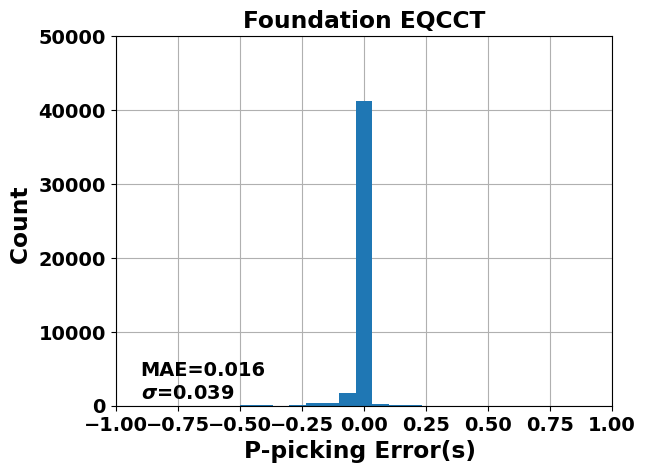

In [5]:
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hist(diftpp, bins=15)
plt.xlim([-1,1])
plt.ylim([0,50000])
plt.xlabel("P-picking Error(s) ",fontsize='large', fontweight='bold')
plt.ylabel("Count ",fontsize='large', fontweight='bold')
plt.title("Foundation EQCCT",fontsize='large', fontweight='bold')

plt.grid()
ax.set_axisbelow(True)
plt.text(-0.9,4000, 'MAE=' + str(np.round(np.mean(np.abs(diftpp)),3)) )
plt.text(-0.9,1000, '$\sigma$=' + str(np.round(np.std((diftpp)),3)) )
plt.show()
#fig.savefig('P_Cal_WC.png', bbox_inches='tight',transparent=True, dpi =100)
